## Introduction to Atmospheric Radar Course - Practical 4

<img src="NCAS_national_centre_logo_transparent.png" alt="NCAS" style="width: 200px; horizontal-align:left"/>


## Developing radar processing chains
### Part 4 - Application of corrections through to QPE

#### Overview
This notebook introduces methods for correcting weather radar data through to radar quantitative precipitation estimates (QPE). We'll apply what we've learned in the previous 3 practical exercises to build a short processing chain and then calculate QPEs using 4 methods.

The final processing chain will:

1. Remove non-meteorological echoes (See practical 4 part 1 and part 2)
2. Process Kdp from differential phase shift (See practical 4 part 3)
3. Calculate specific attenuation using the Z-Phi method (See practical 4 part 3)
4. Correct reflectivity for attenuation (See practical 4 part 3)
5. Calculate QPE in rain using R(A), R(Kdp) and R(Z)
6. Create a hybrid R relation within rain while also using a different R(Z) relation above the melting layer


We'll start as usual by importing the python modules we need for this notebook

In [1]:
import pyart
import pyart.graph.cm_colorblind as pycm
import matplotlib.pyplot as plt
import scipy.ndimage as sciim
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Then we can load an example file known to contain attenuating precipitation, as shown in the lecture and set up a ```RadarMapDisplay``` object for that file, allowing us to plot the coastline which will help give an idea of the source of some of the clutter.

In [2]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/raine/cfradial/calib_v1/sur/20200723/ncas-mobile-x-band-radar-1_sandwith_20200723-094532_SUR_v1.nc'

radar = pyart.io.read(radar_file)
raddisp = pyart.graph.RadarMapDisplay(radar)

We'll now plot up a multipanel PPI plot of 4 of the variables in the file (see practical 3 for more details on creating multi-panel plots). In addition to reflectivity (dBuZ) we'll also plot the co-polar cross correlation (RhoHV) which we'e seen to be a potentially useful discriminant between meteorological and other echoes, differential reflectivity (ZDR) and the signal quality index (SQI). 

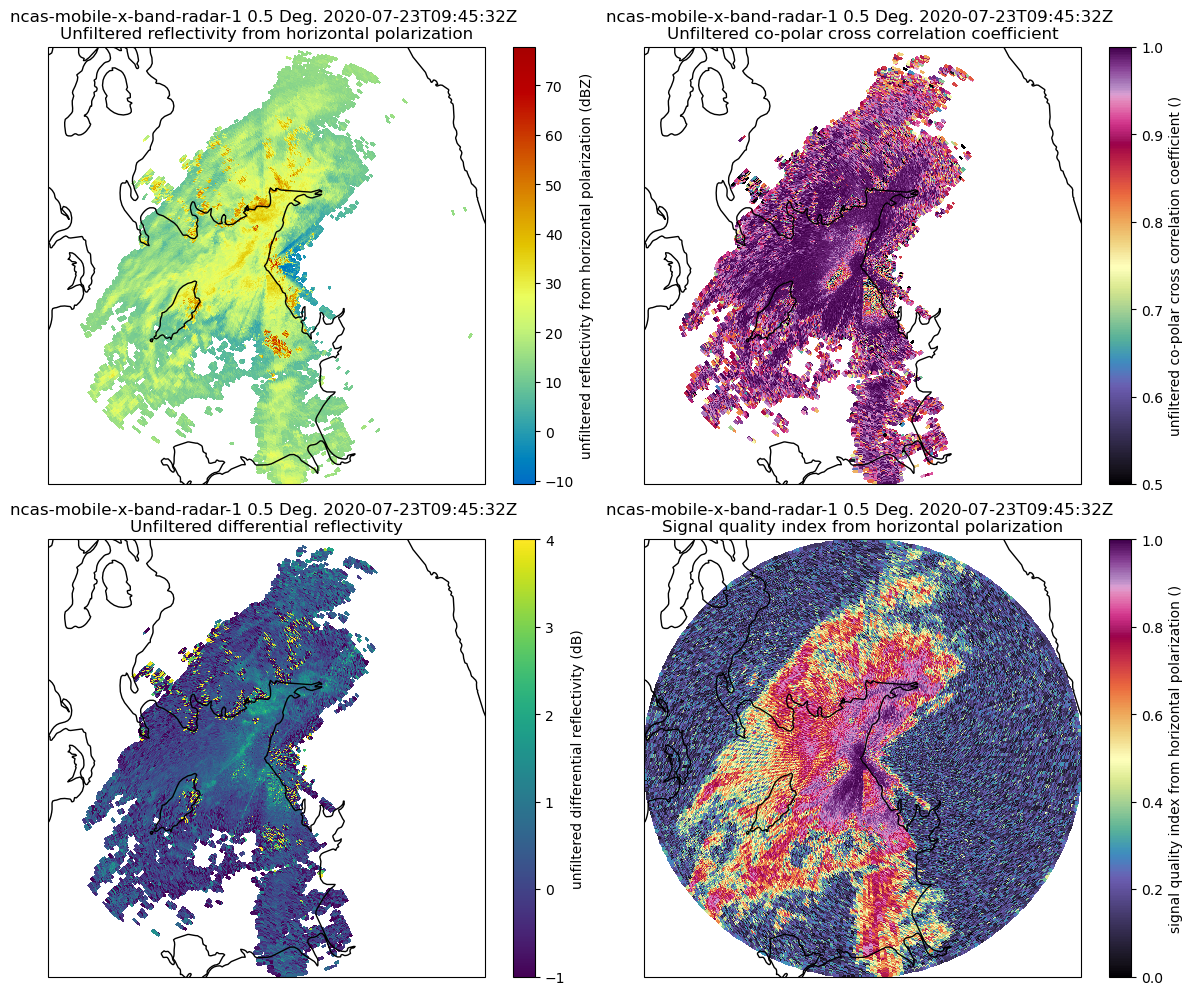

In [3]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     embellish=False,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=0, vmax=1,
                     embellish=False,
                     ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

We will apply the speckle filter to the 'dBuZ' reflectivity field, keeping the default values for the threshold (all echoes above -100dBZ are included) and the size (at least 10 connected gates). We'll recreate our original gatefilter to mask the dBuZ field prior to identifying connected regions (if we simply pass the original, gatefilter1, it will be modified by the despeckle function).

In [4]:
gatefilter3 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter3 = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 'ZDRu',
                                                                 'RhoHVu',
                                                                 'uPhiDPu',
                                                                 'dBuZ',
                                                                 min_rhv=0.85)
gatefilter3.exclude_below('SQI',0.4)
gatefilter3 = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter3)

/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


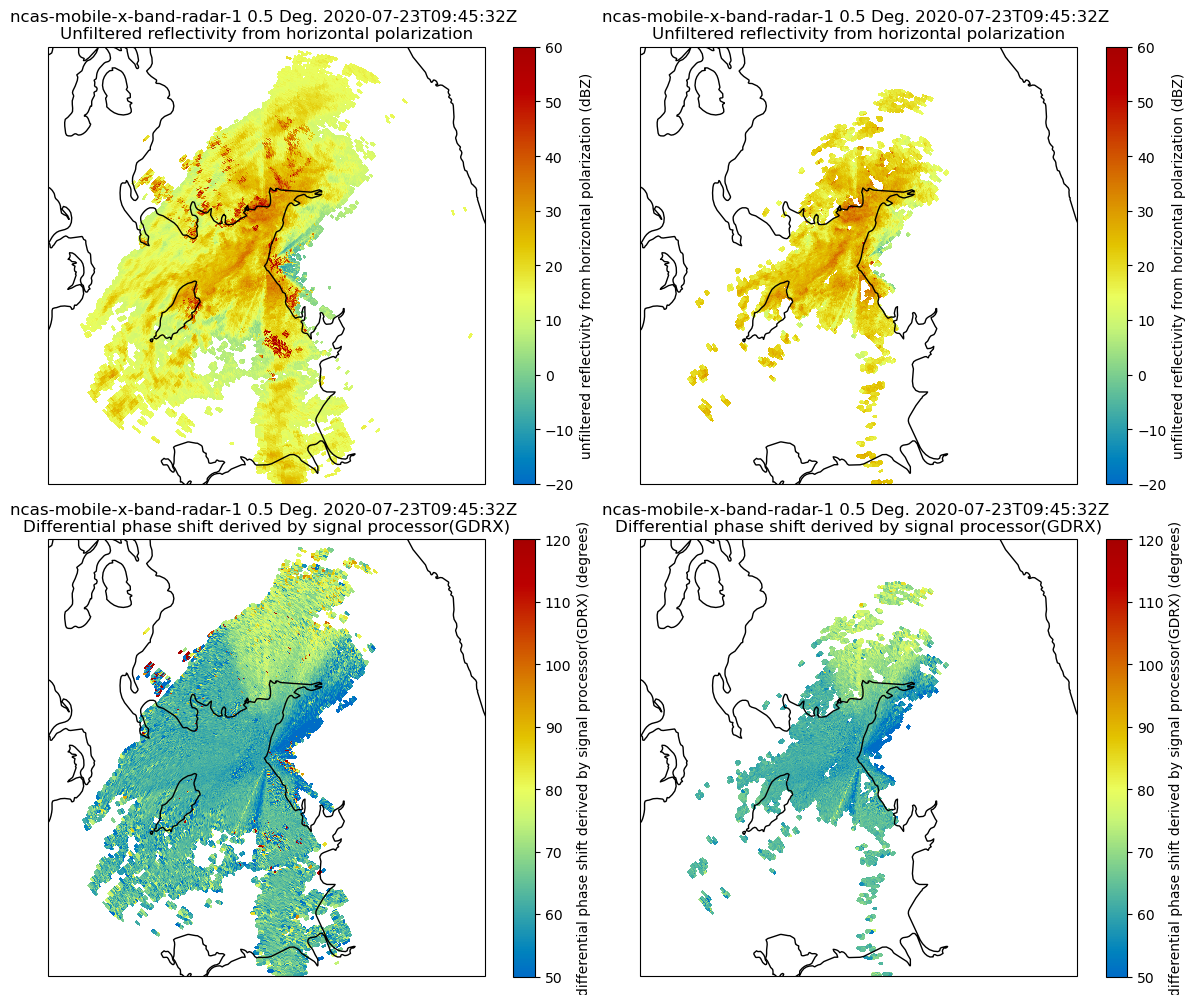

In [8]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     vmin=-20,vmax=60, # Filtering can change the max values, so we'll fix the color for all plots
                 ax=ax1)

ax1.coastlines(resolution='10m')


ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter3,
                     vmin=-20,vmax=60,
                 ax=ax2)
ax2.coastlines(resolution='10m')

ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("uPhiDP", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     vmin=50,vmax=120,
                 ax=ax3)
ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("uPhiDP", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter3,
                     vmin=50,vmax=120,
                 ax=ax4)
ax4.coastlines(resolution='10m')

plt.tight_layout()

In [9]:
pyart.correct.calculate_attenuation_philinear?

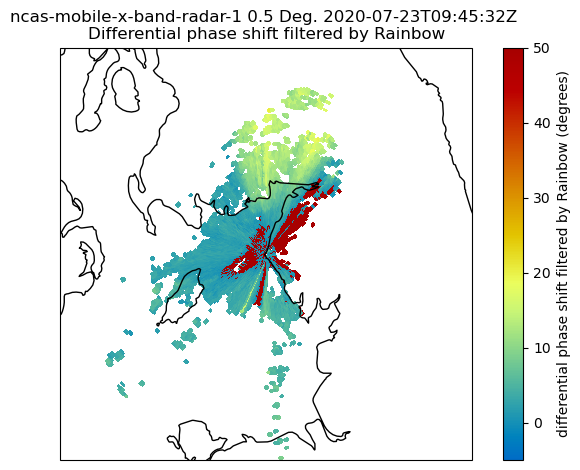

In [11]:
ax4 = plt.subplot(111, projection=proj)
raddisp.plot_ppi_map("PhiDP", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter3,
                     vmin=-5,vmax=50,
                 ax=ax4)
ax4.coastlines(resolution='10m')

plt.tight_layout()

In [12]:
import wradlib

In [52]:
wradlib.atten.correct_attenuation_hb?

In [ ]:
attenuation_hb = wradlib.atten.correct_attenuation_hb(np.where(gatefilter3.gate_included,
                                              radar.fields['dBuZ']['data'],
                                              -30),
                                     coefficients={'a':1.62e-4, # 1.62e-4, 1.15e-4
                                                   'b':0.74, # 0.74, 0.78
                                                   'gate_length':0.15})

In [ ]:
np.argmax(np.max(attenuation_hb,axis=0))

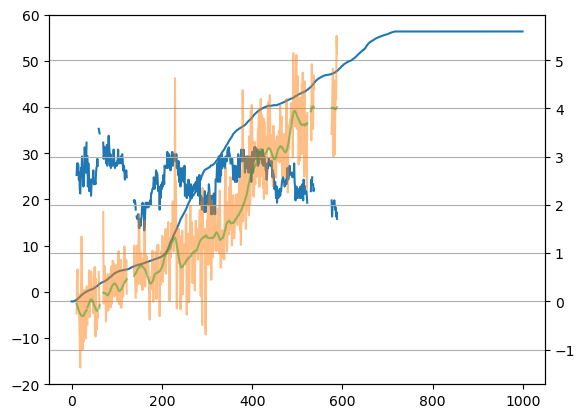

In [85]:
ax1 = plt.subplot(111)
plt.plot(np.where(gatefilter3.gate_included,
                                              radar.fields['dBuZ']['data'],
                                              np.nan)[210])
plt.ylim(-20,60)
ax2 = ax1.twinx()

plt.plot(attenuation_hb[210])
plt.plot(0.27*np.where(gatefilter3.gate_included,
                                              radar.fields['uPhiDP']['data']-60,
                                              np.nan)[210],alpha=0.5)
plt.plot(0.27*np.where(gatefilter3.gate_included,
                                              np.where(radar.fields['PhiDP']['data']>250,
                                                       radar.fields['PhiDP']['data']-360,
                                                       radar.fields['PhiDP']['data'])-1,
                                              np.nan)[210],alpha=0.5)
plt.grid()

In [96]:
kdp_maesaka = pyart.retrieve.kdp_maesaka(radar,gatefilter=gatefilter3,psidp_field='uPhiDP')

In [119]:
kdp_vulp = pyart.retrieve.kdp_vulpiani(radar,gatefilter=gatefilter3,psidp_field='uPhiDP',band='X')

(-5.0, 10.0)

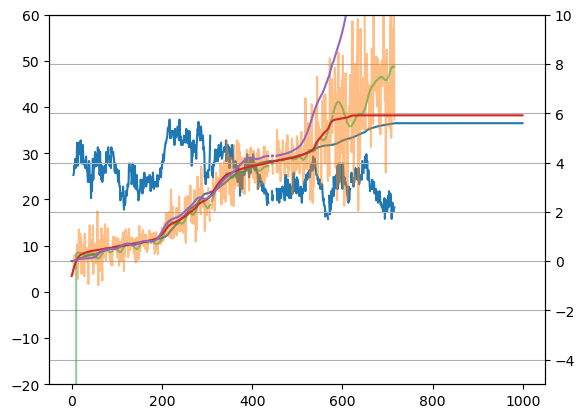

In [132]:
ax1 = plt.subplot(111)
plt.plot(np.where(gatefilter3.gate_included,
                                              radar.fields['dBuZ']['data'],
                                              np.nan)[805])
plt.ylim(-20,60)
ax2 = ax1.twinx()

plt.plot(attenuation_hb[805])
plt.plot(0.27*np.where(gatefilter3.gate_included,
                                              radar.fields['uPhiDP']['data']-58,
                                              np.nan)[805],alpha=0.5)
plt.plot(0.27*np.where(gatefilter3.gate_included,
                                              np.where(radar.fields['PhiDP']['data']>250,
                                                       radar.fields['PhiDP']['data']-360,
                                                       radar.fields['PhiDP']['data'])+1,
                                              np.nan)[805],alpha=0.5)

plt.plot((0.15*2*kdp_maesaka[0]['data'].cumsum(axis=-1)[805]-2.5)*0.27)
plt.plot((0.15*2*kdp_vulp[0]['data'].cumsum(axis=-1)[805])*0.27)
plt.grid()
plt.ylim(-5,10)

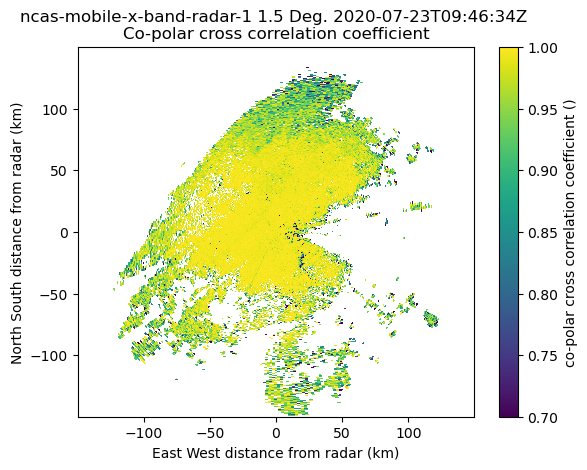

In [136]:
raddisp.plot_ppi('RhoHV',sweep=2,vmin=0.7,vmax=1)

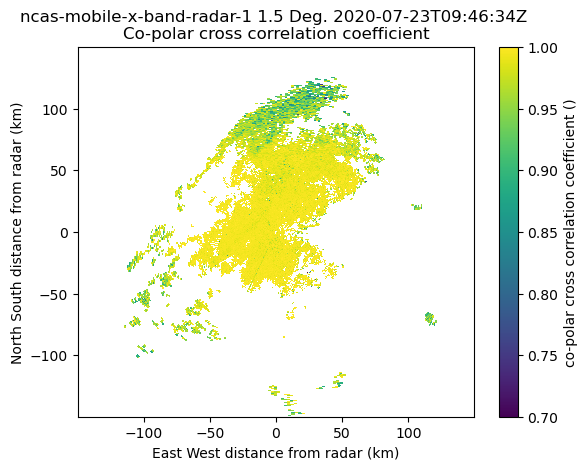

In [137]:
raddisp.plot_ppi('RhoHV',sweep=2,vmin=0.7,vmax=1,gatefilter=gatefilter3)